In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

from sourcesep.models.baseunet import LitBaseUnet
from sourcesep.models.helpers import H5Dataset
from sourcesep.utils.config import load_config

import numpy as np
from torch.utils.data import DataLoader, Subset
import torch

In [2]:
expt = '01_bells_whistles'

paths = load_config(dataset_key='all')
expt_path = paths['root'] / 'results' / expt 
sim_name = '2023-03-25'
h5_filename = str(paths['root'] / "sims" / f"{sim_name}_val.h5")
dataset = H5Dataset(h5_filename=h5_filename, n_timesamples=2048)

Paths are for dataset tagged: all


In [3]:
overlap = 1024
if overlap is not None:
    subset_idx = np.arange(0,len(dataset),step=2048-overlap)
else:
    subset_idx = np.arange(0,len(dataset),step=2048)

dataloader = DataLoader(Subset(dataset, subset_idx),
                        batch_size=subset_idx.size,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True)

In [4]:
batch = next(iter(dataloader))
print(batch['O'].shape)

torch.Size([209, 300, 2048])


In [5]:
# model_name is one of the following:
# ├── best-val-exp-var_epoch=767.ckpt
# ├── best-val-loss_epoch=790.ckpt
# └── exit-model.ckpt

model_name = 'best-val-loss_epoch=790'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = LitBaseUnet.load_from_checkpoint(expt_path / f'{model_name}.ckpt')
model = model.to(device)
model = model.eval()

In [6]:
pred_A_torch = model.A_transform_inv(model.model(batch['O'].to(device)))
pred_A = pred_A_torch.detach().cpu().numpy()

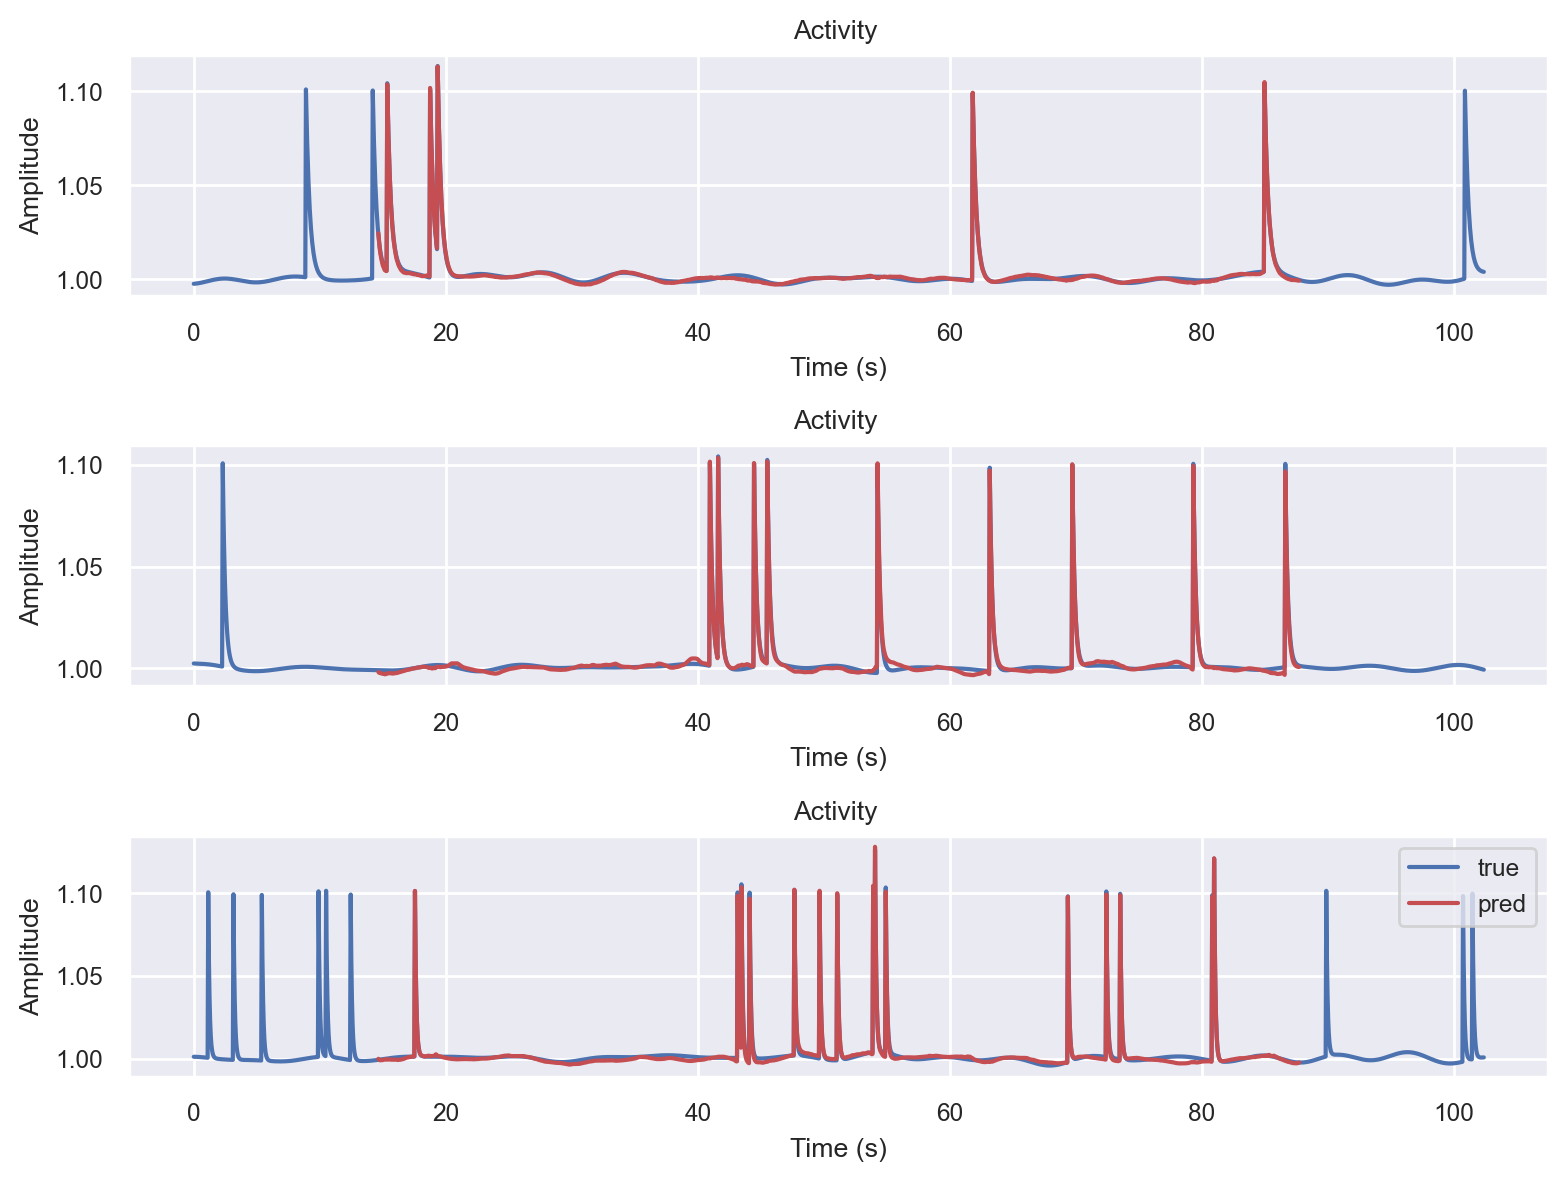

In [7]:
T_arr = np.arange(2048) / dataset.cfg['sensor']['sampling_freq_Hz']
offset = 0.0
batch_idx = 5

f, ax = plt.subplots(3, 1, figsize=(8,6))
for i in range(3):
    ax[i].plot(T_arr, batch['A'][:,i,:].cpu().numpy()[batch_idx,:] + offset, c='b', label='true')
    ax[i].plot(T_arr[model.pad:-model.pad], pred_A[batch_idx,i,:], c='r', label='pred')
    ax[i].set(xlabel='Time (s)', ylabel='Amplitude', title='Activity ')
plt.legend()
plt.tight_layout()
plt.show()

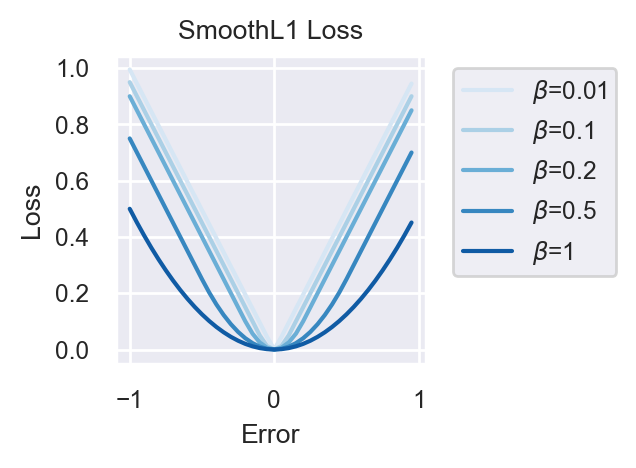

In [8]:
beta_list = [0.01, 0.1, 0.2, 0.5, 1]
f, ax = plt.subplots(1,1,figsize=(2,2))
colors = sns.color_palette('Blues', n_colors=len(beta_list))

for beta in beta_list:
    err = np.arange(-1,1,0.05)
    x = np.zeros_like(err)
    smoothl1 = torch.nn.SmoothL1Loss(beta=beta, reduction='none')
    L = smoothl1(torch.tensor(x), torch.tensor(err))
    L = L.numpy()
    
    ax.plot(err, L, label=rf'$\beta$={beta}', c=colors.pop(0))
ax.set(xlabel='Error', ylabel='Loss', title='SmoothL1 Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()